In [245]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency 
import matplotlib.pyplot as plt

In [246]:
TEN_FIFTYNINE = '10-59'
UNVAXX = 'Unvaccinated'
DBLDOSE = 'Second dose' 

month_map = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
             'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}

In [247]:
def cullDate(d):
    d = d.split('-')
    re_org = "-".join(['20'+d[2], month_map[d[1]], d[0] ])
    return datetime.datetime.strptime(re_org, "%Y-%m-%d")
 
def formatDates(arr):
    return np.array([cullDate(d) for d in arr])

def stripCharacter(arr,c,r=''):
    return np.array([e.replace(c, r) for e in arr])

def str2Int(arr):
    return np.array([int(e) for e in arr])

def statSignificance(p_val):    
    if(p_val < 0.01): return 'green'
    elif(0.01 <= p_val < 0.05): return 'yellow'
    else: return 'red'

In [248]:
dat = pd.read_csv('../data/england_mortality.csv')
dat = dat.assign(week_ending = formatDates(dat['week_ending'].values))
dat = dat.loc[dat['age_grp'] == TEN_FIFTYNINE]
dat = dat.assign(deaths = stripCharacter(dat['deaths'].values,','))
dat = dat.assign(pop = stripCharacter(dat['pop'].values,','))
dat = dat.assign(deaths = str2Int(dat['deaths'].values))
dat = dat.assign(pop = str2Int(dat['pop'].values))
dat = dat.assign(per_100k = 1e5*dat['deaths'].values/dat['pop'].values)
dat.reset_index(drop=True, inplace=True)
dat.head(5)

,week_ending,week_number,vaxx_status,age_grp,deaths,pop,per_tot_pop,per_100k,lwr_ci,upr_ci
0,2021-01-08,1,Unvaccinated,10-59,991,26822400,98.1,3.694673,3.5,3.9
1,2021-01-15,2,Unvaccinated,10-59,1064,26382353,96.5,4.032999,3.8,4.3
2,2021-01-22,3,Unvaccinated,10-59,1071,25883217,94.7,4.137816,3.9,4.4
3,2021-01-29,4,Unvaccinated,10-59,940,25426420,93.0,3.696942,3.5,3.9
4,2021-02-05,5,Unvaccinated,10-59,898,25027294,91.6,3.588083,3.4,3.8


In [249]:
unvaxxed = dat.loc[dat['vaxx_status'] == UNVAXX]
unvaxxed.head(5)

,week_ending,week_number,vaxx_status,age_grp,deaths,pop,per_tot_pop,per_100k,lwr_ci,upr_ci
0,2021-01-08,1,Unvaccinated,10-59,991,26822400,98.1,3.694673,3.5,3.9
1,2021-01-15,2,Unvaccinated,10-59,1064,26382353,96.5,4.032999,3.8,4.3
2,2021-01-22,3,Unvaccinated,10-59,1071,25883217,94.7,4.137816,3.9,4.4
3,2021-01-29,4,Unvaccinated,10-59,940,25426420,93.0,3.696942,3.5,3.9
4,2021-02-05,5,Unvaccinated,10-59,898,25027294,91.6,3.588083,3.4,3.8


In [250]:
vaxxed = dat.loc[dat['vaxx_status'] == DBLDOSE]
vaxxed.head(5)

,week_ending,week_number,vaxx_status,age_grp,deaths,pop,per_tot_pop,per_100k,lwr_ci,upr_ci
114,2021-01-08,1,Second dose,10-59,0,44563,0.2,0.000000,:,:
115,2021-01-15,2,Second dose,10-59,0,70452,0.3,0.000000,:,:
116,2021-01-22,3,Second dose,10-59,1,74082,0.3,1.349856,:,:
117,2021-01-29,4,Second dose,10-59,1,77230,0.3,1.294834,:,:
118,2021-02-05,5,Second dose,10-59,1,84517,0.3,1.183194,:,:


### Perform A/B testing

In [251]:
obs = {}
res_chisq = {}
for k in range(len(vaxxed)):
    res_test = {}
    d = vaxxed['week_number'].values[k]
    pop_vax = vaxxed['pop'].values[k]
    pop_unvax = unvaxxed['pop'].values[k]
    death_vax = vaxxed['deaths'].values[k]
    death_unvax = unvaxxed['deaths'].values[k]
    obs[d] = [[pop_vax, pop_unvax], [death_vax, death_unvax]]
    if(vaxxed['week_ending'].values[k] == unvaxxed['week_ending'].values[k]):
        chi2, p, dof, ex = chi2_contingency(obs[d], correction=False)
        res_test['chi2'], res_test['p'], res_test['dof'], res_test['ex'] = chi2, p, dof, ex
        res_test['code'] = statSignificance(res_test['p'])
        res_chisq[d] = res_test

### Cull Results

In [252]:
N = len(res_chisq)
results = vaxxed.iloc[:,:2] 
results.loc[:,'vax_pop'] = unvaxxed['pop'].values
results.loc[:,'unvax_pop'] = vaxxed['pop'].values
results.loc[:,'vax_deaths'] = vaxxed['deaths'].values
results.loc[:,'unvax_deaths'] = unvaxxed['deaths'].values
results.loc[:,'vax_per_100K'] = vaxxed['per_100k'].values
results.loc[:,'unvax_per_100K'] = unvaxxed['per_100k'].values
results.loc[:,'vax_per_100K'] = vaxxed['per_100k'].values
results.loc[:,'chisq_pval'] = np.array([res_chisq[k]['p'] for k in range(1,N+1)])
results.loc[:,'chisq_code'] = np.array([res_chisq[k]['code'] for k in range(1,N+1)])

In [266]:
results.head(5)

,week_ending,week_number,vax_pop,unvax_pop,vax_deaths,unvax_deaths,vax_per_100K,unvax_per_100K,chisq_pval,chisq_code
114,2021-01-08,1,26822400,44563,0,991,0.000000,3.694673,0.199442,red
115,2021-01-15,2,26382353,70452,0,1064,0.000000,4.032999,0.091868,red
116,2021-01-22,3,25883217,74082,1,1071,1.349856,4.137816,0.238357,red
117,2021-01-29,4,25426420,77230,1,940,1.294834,3.696942,0.272505,red
118,2021-02-05,5,25027294,84517,1,898,1.183194,3.588083,0.243405,red


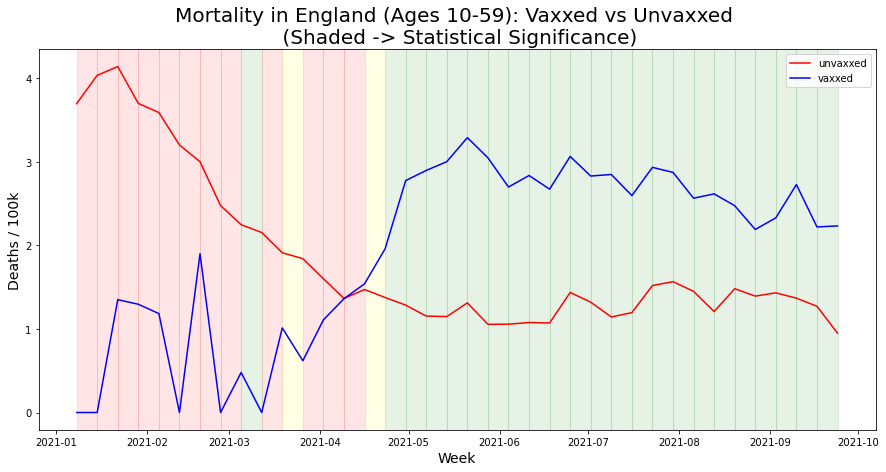

In [265]:
fig = plt.figure(figsize=(15, 7))
plt.plot(results['week_ending'].values, results['unvax_per_100K'].values, label='unvaxxed',color='red')   
plt.plot(results['week_ending'].values, results['vax_per_100K'].values, label='vaxxed',color='blue') 
plt.xlabel('Week', fontsize=14)
plt.ylabel('Deaths / 100k', fontsize=14)
plt.title('Mortality in England (Ages 10-59): Vaxxed vs Unvaxxed \n (Shaded -> Statistical Significance)', fontsize=20)
for k in range(1,N):
    code = results['chisq_code'].values[k]
    last_week = results['week_ending'].values[k-1]
    current_week = results['week_ending'].values[k]
    plt.axvspan(last_week, current_week, alpha=0.1, color=code)    
plt.legend()

fig.savefig('../img/mortality_england_vax_status.png')

In [254]:
unvaxxed.to_csv('../data/unvaxxed.csv')
vaxxed.to_csv('../data/vaxxed.csv')